## Import Library

In [10]:
# Data Handling
import pandas as pd
import datetime as dt
import random
from selenium import webdriver
from selenium.webdriver.common.by import By
import gc

# Data Visualizing
from tqdm import tqdm

#model
from sklearn.model_selection import train_test_split

# etc.
import warnings
warnings.filterwarnings('ignore')
import os
import time

DATA_PATH = 'C:/Users/user/Desktop/bj/Bbeojung.kr/Data'
CHROME_DRIVER = os.path.join(DATA_PATH, 'chromedriver_win32/chromedriver.exe')

## Download DataSet

In [339]:
# # Download df
# driver = webdriver.Chrome(CHROME_DRIVER)
# url = 'https://bigdata.gwangju.go.kr/usr/main/goMain.rd'
# driver.get(url)

# transp_btn = driver.find_element(By.XPATH, '//*[@id="content"]/div[1]/div/div[3]/div/ul/li[18]/a')
# transp_btn.click()

# time.sleep(1)
# page_btn = driver.find_element(By.XPATH, '//*[@id="6"]')
# page_btn.click()

# for page in range(7,24):
#     for i in range(1,11):
#         time.sleep(1)
#         view_btn = driver.find_element(By.XPATH, f'//*[@id="dataSetListBody"]/tr[{i}]/td[8]/a')
#         view_btn.click()
#         while True:
#             try:        
#                 download_btn = driver.find_element(By.XPATH, '//*[@id="apiSrvTbTop"]/tbody/tr[6]/td[1]/a[1]')
#                 download_btn.click()                
#                 tolist_btn = driver.find_element(By.XPATH, '//*[@id="mainForm"]/div[2]/input')
#                 tolist_btn.click()
#             except:
#                 continue
#             break                

#     if page % 10 == 1:
#         time.sleep(1)
#         next_btn = driver.find_element(By.XPATH, f'//*[@id="next"]')
#         next_btn.click()

#     time.sleep(1)
#     page_btn = driver.find_element(By.XPATH, f'//*[@id="{page}"]')
#     page_btn.click()

# driver.quit()


In [ ]:
# def csv_to_parquet(file_name):
#     read_path = os.path.join(DATA_PATH, f'train_data_csv/{file_name}.csv')
#     save_path = os.path.join(DATA_PATH, f'train_data_parquet/{file_name}.parquet')

#     df = pd.read_csv(read_path, encoding='cp949')
#     df.to_parquet(save_path)
#     del df
#     gc.collect()
#     print(file_name, 'Done.')


# path = os.path.join(DATA_PATH, 'train_data_csv')
# for (root, dirs, files) in os.walk(path):
#     for file in files:
#         file_name, _ = os.path.splitext(file)
#         csv_to_parquet(file_name)

## Load DataSet

In [37]:
target_name = 'num'
origin_age = ['PEPL', 'YNGBGS', 'CHILD']
origin_time = ['ATTEND', 'WKDAY_NOON', 'LVFFC', 'RESTDE_NOON']
origin_how = ['TKON', 'GFF']
origin_col = [
'BUSSTAT_BSNM_ID', 'BUSSTAT_BSNM_ROUTEID', 'month', 'weekday', 

'BUSSTAT_TKON_PEPL_ATTEND', 'BUSSTAT_TKON_PEPL_WKDAY_NOON',
'BUSSTAT_TKON_PEPL_LVFFC', 'BUSSTAT_TKON_PEPL_RESTDE_NOON',
'BUSSTAT_TKON_MINOR_ATTEND', 'BUSSTAT_TKON_MINOR_WKDAY_NOON',
'BUSSTAT_TKON_MINOR_LVFFC', 'BUSSTAT_TKON_MINOR_RESTDE_NOON',              

'BUSSTAT_GFF_PEPL_ATTEND', 'BUSSTAT_GFF_PEPL_WKDAY_NOON',
'BUSSTAT_GFF_PEPL_LVFFC', 'BUSSTAT_GFF_PEPL_RESTDE_NOON',
'BUSSTAT_GFF_MINOR_ATTEND', 'BUSSTAT_GFF_MINOR_WKDAY_NOON',
'BUSSTAT_GFF_MINOR_LVFFC', 'BUSSTAT_GFF_MINOR_RESTDE_NOON',                       
]
new_age = ['norm', 'minor']
new_time = ['work', 'wdnoon', 'quit', 'wenoon']
new_how = ['tkon', 'tkoff']
new_col = [
    'bstop', 'bus', 'month', 'weekday',

    'tkon_norm_work', 'tkon_norm_wdnoon', 'tkon_norm_quit', 'tkon_norm_wenoon',
    'tkon_minor_work', 'tkon_minor_wdnoon', 'tkon_minor_quit', 'tkon_minor_wenoon',

    'tkoff_norm_work', 'tkoff_norm_wdnoon', 'tkoff_norm_quit', 'tkoff_norm_wenoon',
    'tkoff_minor_work', 'tkoff_minor_wdnoon', 'tkoff_minor_quit', 'tkoff_minor_wenoon',
]

def id_statistic(train, test, ID, col1, col2):
    # train mean, sum
    train_mean = train.groupby([ID])[target_name].agg([(col1, 'mean')]).reset_index()
    train_sum = train.groupby([ID])[target_name].agg([(col2, 'sum')]).reset_index()
    train_mean_sum = pd.merge(train_mean, train_sum, on=ID)

    # merge
    train_res = pd.merge(train, train_mean_sum, how='left', on=ID)
    test_res = pd.merge(test, train_mean_sum, how='left', on=ID)
    
    return train_res, test_res         


def make_target(df, col):
    how, age, when = col.split('_')
    
    res_df = pd.DataFrame({
        'how' : [how] * len(df[col]),
        'age' : [age] * len(df[col]),
        'when' : [when] * len(df[col]),
        'num' : df[col]
    })

    return pd.concat([df.iloc[:,:4], res_df], axis=1)


def make_dateset(df, how):
    # TKON = TKCAR + TRNSIT
    for a in origin_age:
        for t in origin_time:
            df[f'BUSSTAT_TKON_{a}_{t}'] = df[f'BUSSTAT_TKCAR_{a}_{t}'] + df[f'BUSSTAT_TRNSIT_{a}_{t}']

    # MINOR = YNGBGS + CHILD
    for h in origin_how:
        for t in origin_time:
            df[f'BUSSTAT_{h}_MINOR_{t}'] = df[f'BUSSTAT_{h}_YNGBGS_{t}'] + df[f'BUSSTAT_{h}_CHILD_{t}']

    df['BUSSTAT_BSNM_ID'] = df['BUSSTAT_BSNM_ID'].astype(str)
    df['BUSSTAT_BSNM_ROUTEID'] = df['BUSSTAT_BSNM_ROUTEID'].astype(str)
    date_col = pd.to_datetime(df.BUSSTAT_DT, format='%Y%m%d')
    df['month'] = date_col.apply(lambda x: x.month)
    df['weekday'] = date_col.dt.weekday

    # Select Columns
    df = df[origin_col]
    df.columns = new_col

    # make target
    data = pd.DataFrame()
    for a in new_age:
        for t in new_time:
            for h in new_how:
                data = pd.concat([data, make_target(df, f'{h}_{a}_{t}')])

    # select col / split
    col = [
        'bstop', 'bus', 'month', 'weekday',
        'how', 'age', 'when', 'num'
    ]        
    train, test = train_test_split(data[col], test_size=0.3, shuffle=True, random_state=123)            


    # feature engineering
    col_list = ['bstop', 'bus', 'month', 'weekday', 'age', 'when']
    for col1 in col_list:
        for col2 in col_list:
            if col1 != col2:
                train[col1+'_'+col2] = train[col1].astype(str) + '_' + train[col2].astype(str)
                test[col1+'_'+col2] = test[col1].astype(str) + '_' + test[col2].astype(str)

                train, test = id_statistic(train, test, col1+'_'+col2, 'mean_'+col1+'_'+col2, 'sum_'+col1+'_'+col2)
    for col in col_list:
        train, test = id_statistic(train, test, col, 'mean_'+col, 'sum_'+col)          


    # select how
    train = train[train.how == how]
    test = test[test.how == how]

    col = [
        'mean_bstop_bus', 'sum_bstop_bus', 'mean_bstop_month', 'sum_bstop_month',
        'mean_bstop_weekday', 'sum_bstop_weekday', 'mean_bstop_age', 'sum_bstop_age',
        'mean_bstop_when', 'sum_bstop_when', 'mean_bus_bstop', 'sum_bus_bstop',
        'mean_bus_month', 'sum_bus_month', 'mean_bus_weekday', 'sum_bus_weekday',
        'mean_bus_age', 'sum_bus_age', 'mean_bus_when', 'sum_bus_when',
        'mean_month_bstop', 'sum_month_bstop', 'mean_month_bus', 'sum_month_bus',
        'mean_month_weekday', 'sum_month_weekday', 'mean_month_age', 'sum_month_age',
        'mean_month_when', 'sum_month_when', 'mean_weekday_bstop', 'sum_weekday_bstop',
        'mean_weekday_bus', 'sum_weekday_bus', 'mean_weekday_month', 'sum_weekday_month',
        'mean_weekday_age', 'sum_weekday_age', 'mean_weekday_when', 'sum_weekday_when',
        'mean_age_bstop', 'sum_age_bstop', 'mean_age_bus', 'sum_age_bus',
        'mean_age_month', 'sum_age_month', 'mean_age_weekday', 'sum_age_weekday',
        'mean_age_when', 'sum_age_when', 'mean_when_bstop', 'sum_when_bstop',
        'mean_when_bus', 'sum_when_bus', 'mean_when_month', 'sum_when_month',
        'mean_when_weekday', 'sum_when_weekday', 'mean_when_age', 'sum_when_age',
        'mean_bstop', 'sum_bstop', 'mean_bus', 'sum_bus', 'mean_month', 'sum_month', 'mean_weekday', 'sum_weekday', 'mean_age', 'sum_age', 'mean_when', 'sum_when',
        'num'
        ]

    return train[col], test[col]

In [38]:
train = pd.DataFrame()
test = pd.DataFrame()
data_path = os.path.join(DATA_PATH, 'train_data_parquet')
sample_num = 1000

for (root, dirs, files) in os.walk(data_path):
    for file in tqdm(files):
        tmp_df = pd.read_parquet( os.path.join(data_path, file) )
        tmp_df = tmp_df.iloc[random.sample(tmp_df.index.tolist(), sample_num),:]

        train_tmp, test_tmp = make_dateset( tmp_df, 'tkon' )
        train = pd.concat([train, train_tmp])
        test = pd.concat([test, test_tmp])

        del tmp_df, train_tmp, test_tmp
        gc.collect()


train.to_parquet(os.path.join(DATA_PATH, f'final_dataset/train_{sample_num}.parquet'))        
train.to_parquet(os.path.join(DATA_PATH, f'final_dataset/test_{sample_num}.parquet'))        

100%|██████████| 220/220 [06:32<00:00,  1.78s/it]


### 7) Predict & Evaluate Model

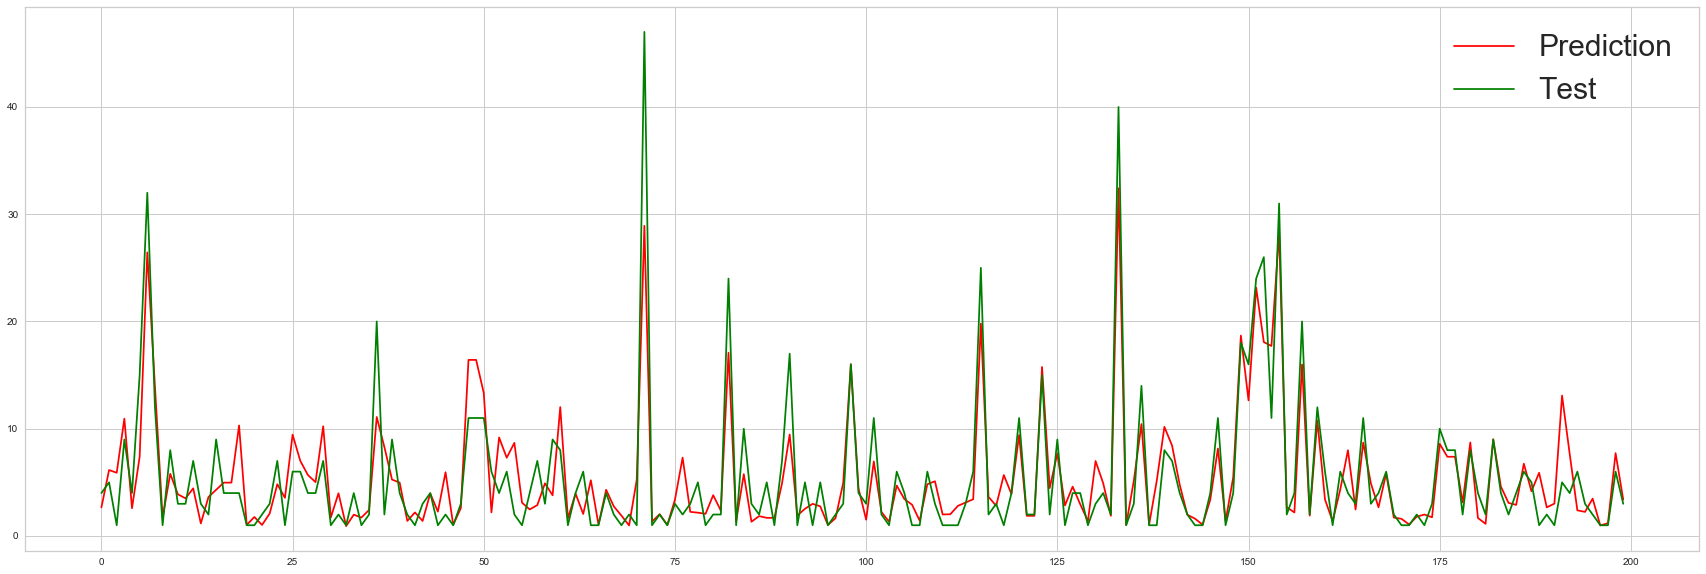

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

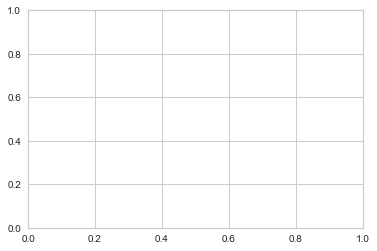

In [80]:
evaluate_model(final_model)

### 2) 모델 저장

In [127]:
joblib.dump(final_model, 'C:/Users/user/Desktop/7_model_pycaret.pkl')

['C:/Users/user/Desktop/7_model_pycaret.pkl']

#### - 1차 모델

In [ ]:
path = "/content/drive/MyDrive/BusProject/Model/bus_model_prototype.pkl"
loaded_model = joblib.load(path)
loaded_model

RandomForestRegressor(criterion='mse', random_state=1217)

In [ ]:
test_feature = x_test.iloc[:,:-6]
test_feature.head()

,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
794737,0,0,0,0,1,0,0
793414,0,0,0,0,1,0,0
992280,0,0,1,0,0,0,0
1209317,1,0,0,0,0,0,0
457202,0,0,0,0,1,0,0


In [ ]:
y_pred = loaded_model.predict(test_feature)

In [ ]:
fig = plt.figure(figsize=(10,10))
fig.add_subplot()
plt.plot(y_pred[:100])
plt.plot(y_test.reset_index()[target_time][:100])

  #### - 2차 모델

In [ ]:
path2 = "/content/drive/MyDrive/BusProject/Model/bus_model_2.pkl"
loaded_model2 = joblib.load(path2)
loaded_model2

RandomForestRegressor(random_state=1217)

In [ ]:
test_feature2 = x_test.iloc[:,:-2]
test_feature2.head()

,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,기온,강수량,풍속,습도
794737,0,0,0,0,1,0,0,9,0,0,88
793414,0,0,0,0,1,0,0,9,0,2,99
992280,0,0,1,0,0,0,0,11,0,1,40
1209317,1,0,0,0,0,0,0,4,0,0,45
457202,0,0,0,0,1,0,0,10,0,0,69


In [ ]:
y_pred2 = loaded_model2.predict(test_feature2)

In [ ]:
fig = plt.figure(figsize=(30,20))
fig.add_subplot()
plt.plot(y_pred2[-500:].tolist())
plt.plot(y_test[-500:].tolist())

#### - 3차 모델

In [ ]:
path3 = "/content/drive/MyDrive/BusProject/Model/bus_model_3.pkl"
loaded_model3 = joblib.load(path3)
loaded_model3

RandomForestRegressor(random_state=1217)

In [ ]:
test_feature3 = x_test
test_feature3.head()

,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,기온,강수량,풍속,습도,hollyday,weekend
794737,0,0,0,0,1,0,0,9,0,0,88,0,0
793414,0,0,0,0,1,0,0,9,0,2,99,0,0
992280,0,0,1,0,0,0,0,11,0,1,40,0,0
1209317,1,0,0,0,0,0,0,4,0,0,45,0,0
457202,0,0,0,0,1,0,0,10,0,0,69,0,0


In [ ]:
y_pred3 = loaded_model3.predict(test_feature3)

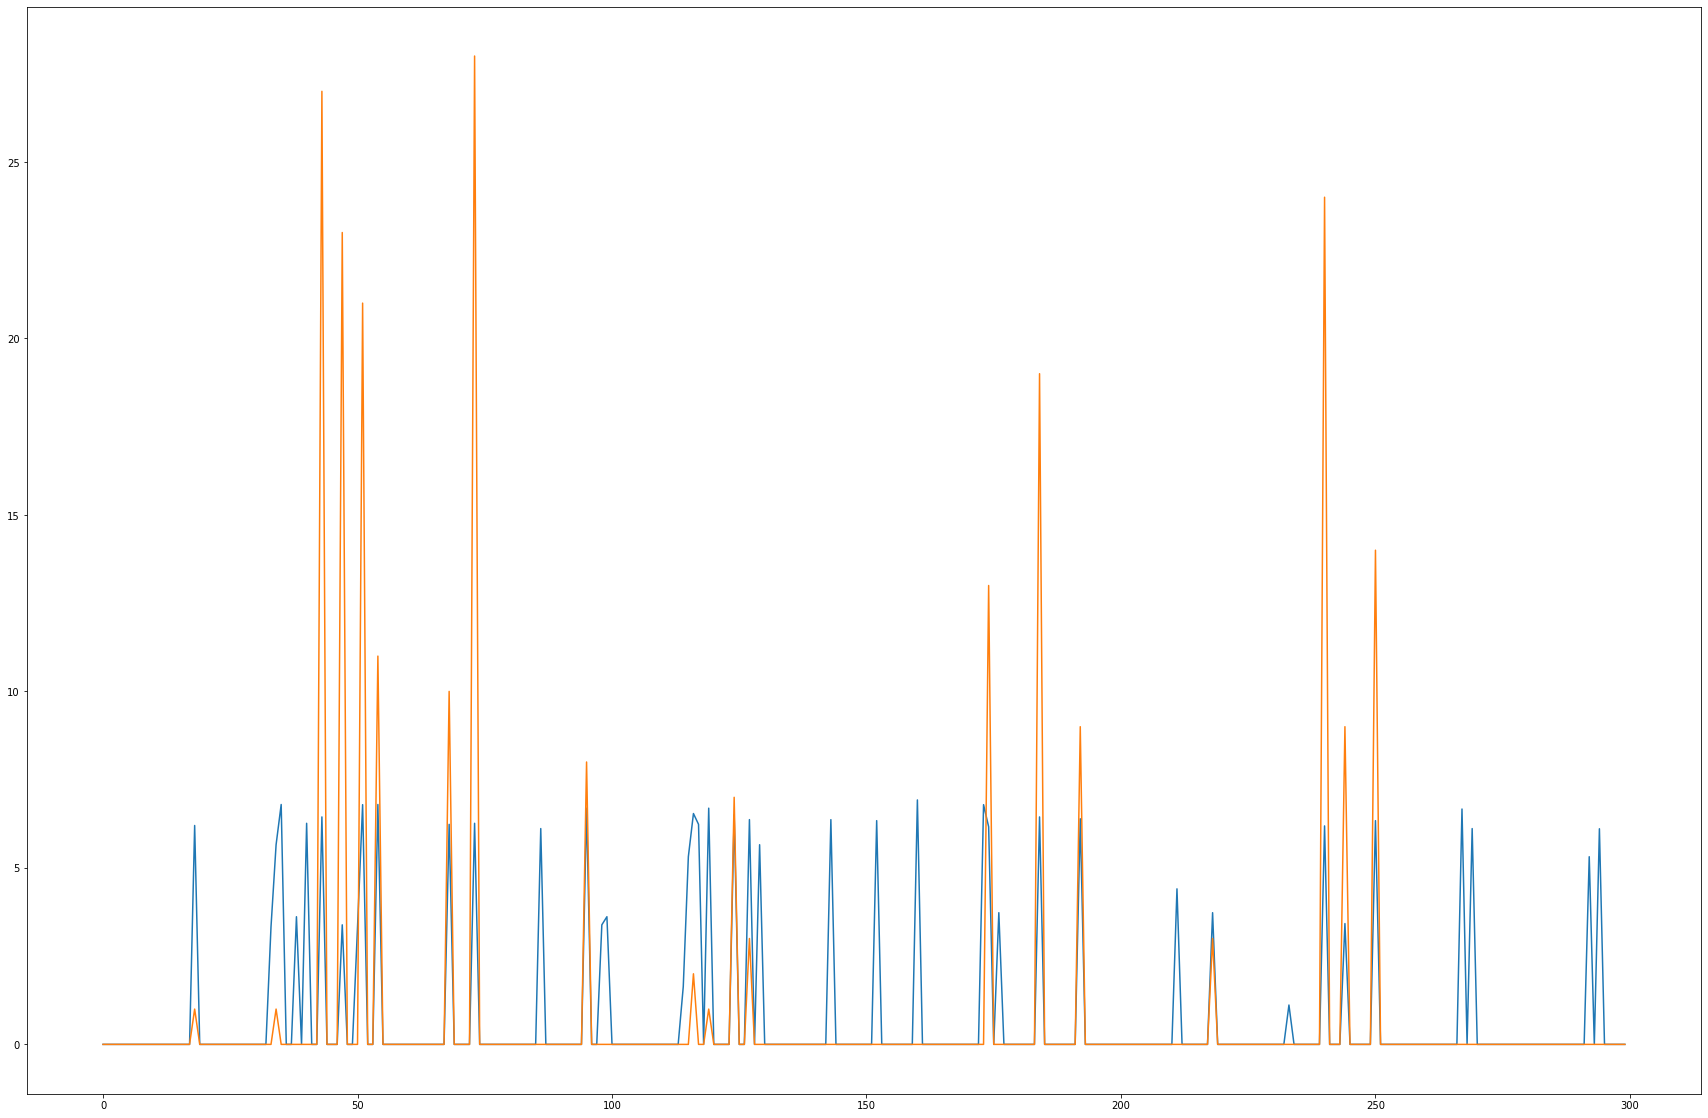

In [ ]:
fig = plt.figure(figsize=(20,10))
fig.add_subplot()
plt.plot(y_pred3[:300].tolist())
plt.plot(y_test[:300].tolist())

#### - 5차 모델

In [ ]:
path5 = "/content/drive/MyDrive/BusProject/Model/bus_model_5.pkl"
loaded_model5 = joblib.load(path5)
loaded_model5

In [ ]:
test_feature5 = x_test
test_feature5.head()

In [ ]:
y_pred5 = loaded_model5.predict(test_feature5)

In [ ]:
fig = plt.figure(figsize=(20,10))
fig.add_subplot()
plt.plot(y_pred3[:300].tolist())
plt.plot(y_test[:300].tolist())

#### - 6차 모델

In [128]:
path6 = 'C:/Users/user/Desktop/7_model_pycaret.pkl'
loaded_model6 = joblib.load(path6)
loaded_model6

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [130]:
predict_model(loaded_model6, x_test)

,dis_5159,dis_5745,dis_5445,dis_4475,dis_4406,dis_2002,dis_2232,dis_1130,dis_3236,population,...,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,route_encode,id_encode,route_id_weekday_encode,route_id_encode,Label
0,9.581833,6.252138,6.311139,3.546569,2.192326,1.493428,3.455257,4.007896,6.064677,12111,...,0,1,0,0,0,114,1089,32923,7473,2.663551
1,10.706573,4.344623,1.125039,4.575152,7.454250,7.082251,6.894355,10.241630,12.120630,20323,...,0,0,0,0,0,107,1565,30534,6890,6.148209
2,20.391226,21.361850,22.249558,18.405741,15.011839,15.475012,16.922409,11.988412,10.935525,20323,...,0,1,0,0,0,90,1972,25354,5746,5.893987
3,5.479437,4.421392,6.591980,6.976321,6.225567,2.939188,0.660887,6.519245,6.209357,30457,...,0,0,0,1,0,30,362,7615,1818,10.942248
4,8.820541,6.241373,6.835669,4.618329,2.902550,0.451779,2.719823,3.723538,5.186784,8134,...,0,0,0,1,0,44,169,12266,2814,2.584458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60271,11.753156,9.835634,10.040162,6.183493,2.784329,3.845887,6.043678,0.507176,4.057669,20323,...,0,0,0,0,0,53,106,15369,3503,4.894291
60272,8.397831,6.028023,6.829308,4.944324,3.334112,0.053122,2.316151,3.947626,5.091079,8134,...,0,0,0,0,0,92,166,26060,5913,9.839232
60273,10.083644,8.113959,8.595875,5.474090,2.536123,2.073128,4.264070,1.848196,3.961700,3713,...,0,1,0,0,0,110,299,31472,7084,9.341997
60274,0.843339,5.632695,8.891121,11.241019,10.930730,7.640042,5.354996,10.941888,9.543192,11122,...,1,0,0,0,0,96,1369,27431,6210,4.996772
